In [156]:
%load_ext autoreload
%autoreload 2
%run nnn/ipynb_init.py
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 640x480 with 0 Axes>

In [157]:
agg_result_file='./data/uv_melt/uvmelt_agg_230502.csv'
uv_df = pd.read_csv(agg_result_file, index_col=1)
arr = pd.read_csv('./data/models/raw/arr_v0.csv', index_col=0)
data_split_dict = fileio.read_json('./data/models/raw/data_split.json')

# Update data split

Remove the variants measured by UV melting from the training set.

In [4]:
# arr = pd.read_csv('./data/models/raw/arr_v0.csv', index_col=0)
# arr.dropna(subset=['Series'], inplace=True)
arr_1M = pd.read_csv('./data/models/raw/arr_1M.csv', index_col=0)

In [247]:
from sklearn.model_selection import train_test_split

ind2split = list(set(arr_1M.index) - set(uv_df.index))
series2split = arr_1M.loc[ind2split, 'Series']

train_val_ind, test_ind = train_test_split(ind2split, test_size=.1,
                                       random_state=42, stratify=series2split)
train_ind, val_ind = train_test_split(arr_1M.loc[train_val_ind,:].index, test_size=.1,
                                      random_state=43, stratify=arr_1M.loc[train_val_ind,:].Series)
test_ind += list(set(uv_df.index) & set(arr.index))
n_train, n_val, n_test = len(train_ind), len(val_ind), len(test_ind)
print(n_train, n_val, n_test)

split_dict = dict(train_ind=train_ind.tolist(),
                  val_ind=val_ind.tolist(),
                  test_ind=test_ind)
with open('./data/models/raw/data_split.json', 'w') as fh:
    json.dump(split_dict, fh, indent=4)

24936 2771 3146


In [248]:
len(set(uv_df.index) & set(arr.index))

67

# First attempt

I overwrote the triloop parameters in the parameter set file and saw a change in the prediction results. More salt and offset correction needs to be applied before it is usable.

In [8]:
[x for x in uv_df.index if x.startswith('TRI')]

['TRINNN162',
 'TRINNN162',
 'TRINNN445',
 'TRINNN452',
 'TRINNN470',
 'TRINNN512',
 'TRINNN520',
 'TRINNN544']

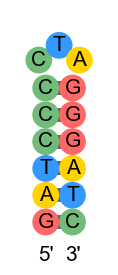

-1.9906842590104945

In [96]:
seqid = 'TRINNN996'
seq = arr.loc[seqid, 'RefSeq']
struct = arr.loc[seqid, 'TargetStruct']
draw_struct(seq, struct)

arr.loc[seqid, 'dG_37']#, uv_df.loc[seqid, 'dG_37_uv'], arr.loc[seqid, 'dH'], uv_df.loc[seqid, 'dH_uv']

In [87]:
util.get_seq_ensemble_dG(seq, celsius=37, sodium=0.088)

-3.0344754698584784

In [88]:
util.get_seq_ensemble_dG(seq, celsius=37, sodium=1)

-4.353346051253523

In [97]:
util.get_nupack_dH_dS_Tm_dG_37(seq, struct, sodium=0.088, return_dict=True, param_set='dna04')

{'dH': -39.59999999999999,
 'dS': -0.11940253556642866,
 'Tm': 58.501248544624445,
 'dG_37': -2.567303594072143}

In [98]:
util.get_nupack_dH_dS_Tm_dG_37(seq, struct, sodium=0.088, return_dict=True, param_set='./models/dna-nnn.json')

{'dH': -34.73214998436219,
 'dS': -0.10932023314550882,
 'Tm': 44.56017116412988,
 'dG_37': -0.8264796742826314}

In [100]:
util.get_nupack_dH_dS_Tm_dG_37(seq, struct, sodium=0.088, return_dict=True, param_set='./models/dna-nnn.json')

{'dH': -34.73214998436219,
 'dS': -0.10932023314550882,
 'Tm': 44.56017116412988,
 'dG_37': -0.8264796742826314}

In [30]:
lr = fileio.read_pickle('./data/models/saved/ols_dG_37_model.pkl')

In [41]:
triloop_param = lr.coef_df.loc[[x for x in lr.coef_df.index if x.endswith('_...')]]
closing_param = lr.coef_df.loc[[x for x in lr.coef_df.index if x.endswith('_(+)')]]

triloop_list = []
param_list = []
for triloop in triloop_param.index:
    for closing in closing_param.index:
        closing_pair = closing.split('_')[0]
        full_triloop = closing_pair[0] + triloop.split('_')[0] + closing_pair[2]
        triloop_list.append(full_triloop)
        param_list.append(triloop_param.loc[triloop][0] + closing_param.loc[closing][0])
        
triloop_df = pd.DataFrame(index = triloop_list, data=param_list, columns=['dG_37'])

In [43]:
param_set_file = './models/dna-nnn.json'
param_set_dict = fileio.read_json(param_set_file)

triloop_dict = triloop_df.to_dict()
param_set_dict['dG']['hairpin_triloop'] = triloop_dict['dG_37']

In [58]:
param_set_dict['dG']['hairpin_triloop']

{'AAAAT': 0.7028274277094955,
 'CAAAG': -0.2779713094583732,
 'GAAAC': 0.40048998584186846,
 'TAAAA': 0.37452855603513335,
 'AAACT': 0.5710587369609939,
 'CAACG': -0.40974000020687484,
 'GAACC': 0.2687212950933668,
 'TAACA': 0.24275986528663168,
 'AAAGT': 0.6412419827926623,
 'CAAGG': -0.3395567543752063,
 'GAAGC': 0.3389045409250353,
 'TAAGA': 0.3129431111183002,
 'AAATT': 0.8472064135173741,
 'CAATG': -0.13359232365049456,
 'GAATC': 0.544868971649747,
 'TAATA': 0.518907541843012,
 'AACAT': 0.3581004563534656,
 'CACAG': -0.622698280814403,
 'GACAC': 0.05576301448583852,
 'TACAA': 0.029801584679103446,
 'AACCT': 0.50036910873936,
 'CACCG': -0.48042962842850867,
 'GACCC': 0.19803166687173296,
 'TACCA': 0.1720702370649979,
 'AACGT': 0.6233372274434811,
 'CACGG': -0.3574615097243876,
 'GACGC': 0.320999785575854,
 'TACGA': 0.2950383557691189,
 'AACTT': 0.5343097131946686,
 'CACTG': -0.44648902397320017,
 'GACTC': 0.23197227132704146,
 'TACTA': 0.20601084152030635,
 'AAGAT': 0.7012536296016

In [60]:
fileio.write_json(param_set_dict, param_set_file)

# Applying adjustments to triloops

Here I correct array data with systematic offset in Tm, salt correct to 1M Na, fit triloop parameters , and adjust the offset based on the way NUPACK parameterizes things.

## Adjust offset

Simply add an offset to Tm and adjust dG_37 and dS.

(-4.0, 0.0)

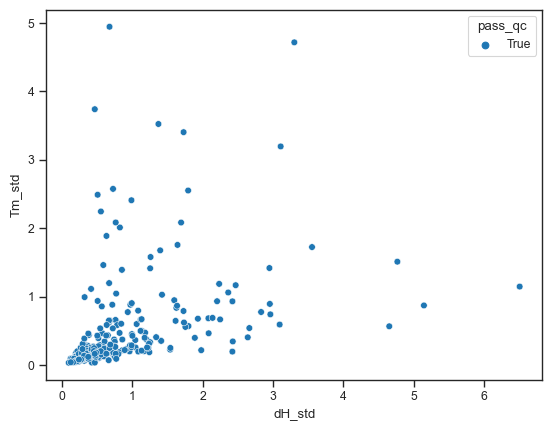

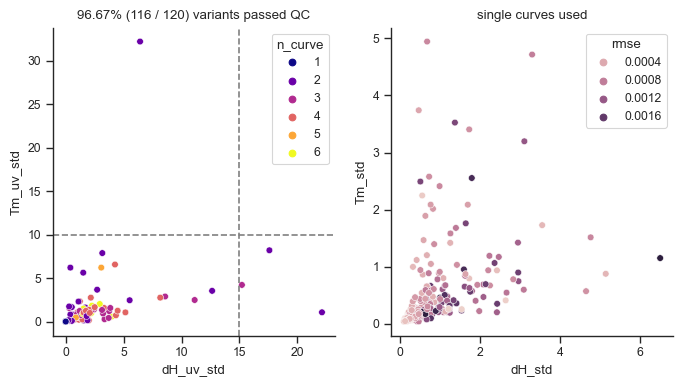

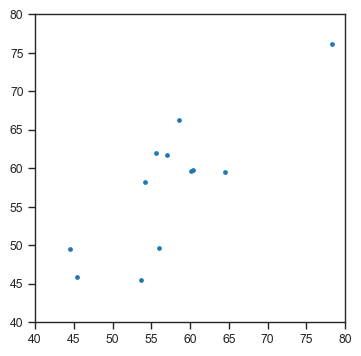

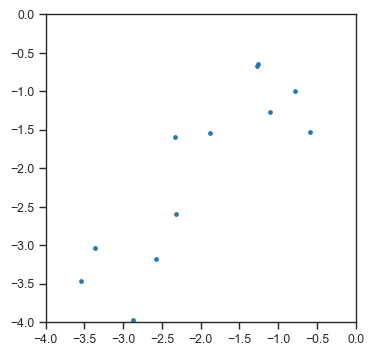

In [159]:
"""
Get the offset the violent way
"""
# copy pasted from command center for convenience
# only one peak found by AnalyzePeaks
hplc_clean_seqid = ["WC68_stem_3p", "WC68_stem_5p", "WC1025_split_5p", \
"WC1025_split_3p", "WC1375_stem_5p", "WC1375_stem_3p", "DMM004_5p", \
"DMM004_3p", "DMM005_5p", "DMM005_3p", "DMM006_5p", "DMM007_5p", \
"DMM007_3p", "BC0", "BC1", "BC6", "BC7", "BC8", "BC9", "BC10", \
"BC11", "MMCNNN2328", "MMCNNN2331", "MMCNNN2334", "MMCNNN2335", \
"MMCNNN2336", "MMCNNN2337", "MMTM1325", "MMTM176", "MMTM178", \
"MMTM179", "MMTM181", "MMTM185", "MMTM189", "MMTM1917", "MMTM29", \
"MMTM397", "MMTM509", "MMTM877", "DMM003_3p_rc", "DMM004_3p_rc", \
"DMM005_3p_rc", "DMM006_3p_rc", "DMM007_3p_rc", "TETNN1003", \
"TETNN999", "TETNN963", "TETNN979", "TETNNN1696", "TETNNN2082", \
"TETNNN1570", "HP002", "HP003", "HP004", "HP005", "HP007", "HP008", \
"HP010", "HP011", "HP012", "HP014", "HP015", "HP016", "HP017", \
"HP018", "HP019", "HP021", "HP022", "HP023", "HP024"]

sample_sheet_file = './data/uv_melt/ECLTables/ECLSampleSheet230502.csv'
datadir="./data/uv_melt/ECLExportAuto"
result_file='./data/uv_melt/uvmelt_230502_2.csv'
agg_result_file='./data/uv_melt/uvmelt_agg_230502.csv'

result_df = pd.read_csv(result_file, index_col=0)
result_agg_df = uv.agg_fit_result(uvmelt_result_file=result_file,
                               agg_result_file=agg_result_file,
                               single_curve_qc_criteria='rmse < 0.002 & dH_std < 10 & Tm_std < 5 & dH < 0 & dH > -100 & Tm > 0 & Tm < 120',
                               Tm_std_thresh=10, dH_std_thresh=15,
                               sample_sheet_file=sample_sheet_file, 
                               clean=True, only_use_cooling=True)

result_agg_df = result_agg_df[result_agg_df.SEQID.isin(hplc_clean_seqid)]

arr = pd.read_csv('./data/models/raw/arr_v0.csv', index_col=0)
vf = result_agg_df.query('is_hairpin & Na_mM == 25').sort_values(by=['conc_uM', 'n_curve', 'curve_date']).drop_duplicates(keep='last').merge(arr, how='left', on='SEQID')

df_q = vf.dropna(subset=['Tm', 'dG_37'])#.query(plot_query)
df_q.dG_37_uv_std = 0

dTm = np.median(df_q.Tm_uv - df_q.Tm)
df_q['Tm_adj'] = df_q.Tm + dTm
df_q['dG_37_adj'] = util.get_dG(dH=df_q.dH, Tm=df_q.Tm_adj, celsius=37)

plt.figure(figsize=(4,4))
plt.plot(df_q.Tm_uv, df_q.Tm_adj, '.')
lim = [40,80]
plt.xlim(lim)
plt.ylim(lim)

plt.figure(figsize=(4,4))
plt.plot(df_q.dG_37_uv, df_q.dG_37_adj, '.')
lim = [-4,0]
plt.xlim(lim)
plt.ylim(lim)

In [160]:
def adjust_offset(dH, Tm, dTm):
    Tm_adj = Tm + dTm
    dG_37_adj = util.get_dG(dH=dH, Tm=Tm_adj, celsius=37)
    dS_adj = dH / (Tm_adj + 273.15)
    return dict(dH=dH, dS=dS_adj, Tm=Tm_adj, dG_37=dG_37_adj)

In [161]:
cols = ['dH_se', 'Tm_se', 'dG_37_se', 'dS_se', 'RefSeq', 'TargetStruct', 'Series']
arr_adj = pd.DataFrame(adjust_offset(arr.dH, arr.Tm, dTm))
arr_adj[cols] = arr[cols]

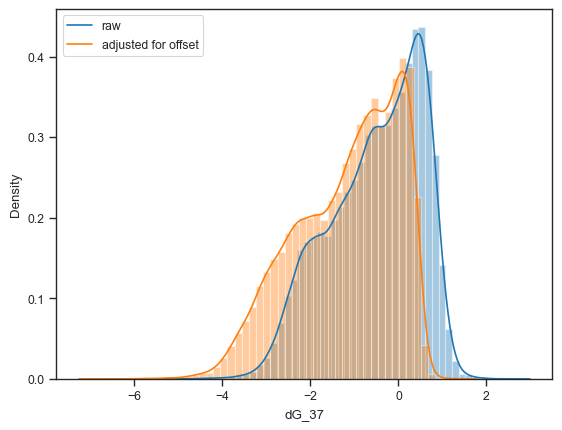

In [162]:
sns.distplot(arr.dG_37)
sns.distplot(arr_adj.dG_37)
plt.legend(['raw', 'adjusted for offset'])

## Salt correct array data to fucking 1M Na+

`arr_adj` -> `arr_1M`

In [163]:
%%time
param_names = ['dH','dS','Tm', 'dG_37']
arr_1M = pd.DataFrame(index=arr_adj.index, columns=param_names)

for i, row in arr_adj.iterrows():
    param_dict = util.get_Na_adjusted_param(Na=1.0, dH=row.dH, Tm=row.Tm, seq=row.RefSeq)
    arr_1M.loc[i,:] = param_dict

# cols = ['dH_se', 'Tm_se', 'dG_37_se', 'dS_se', 'RefSeq', 'TargetStruct', 'Series']
arr_1M[cols] = arr[cols]

arr_1M.dropna(subset=['RefSeq','TargetStruct'], inplace=True)

CPU times: user 5.94 s, sys: 91.3 ms, total: 6.03 s
Wall time: 5.97 s


In [240]:
# remove dangles
sd_mask = arr_1M.apply(lambda row: not row.name.startswith('SD'), axis=1)
arr_1M = arr_1M[sd_mask.values]

In [242]:
arr_1M.to_csv('./data/models/raw/arr_1M.csv')

In [243]:
arr_1M = pd.read_csv('./data/models/raw/arr_1M.csv', index_col=0)

## Fit parameters based on the 1M Na+ data

In [14]:
%%time
feats = mf.get_feature_count_matrix(arr_1M, feature_method='get_feature_list', 
                                    fit_intercept=False, symmetry=False, sep_base_stack=True)
print(feats.shape)

(30922, 1371)
CPU times: user 27 s, sys: 256 ms, total: 27.3 s
Wall time: 27.1 s


CPU times: user 7min 21s, sys: 5min 30s, total: 12min 51s
Wall time: 14min 37s


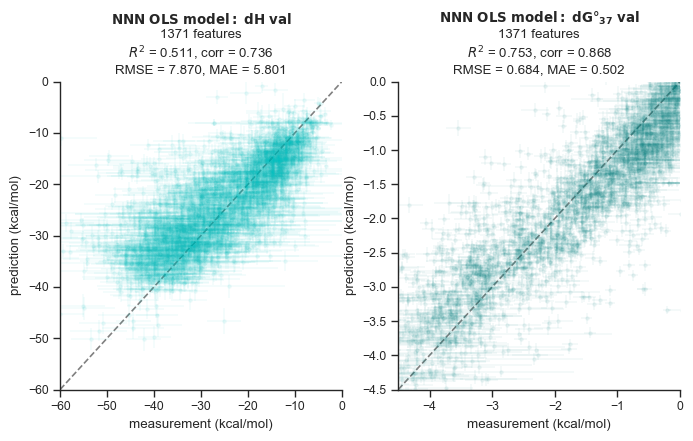

In [20]:
%%time 
fig, ax = plt.subplots(1, 2, figsize=(8,4))
lr_dH = mf.fit_param(arr_1M, data_split_dict, param='dH', feats=feats, ax=ax[0])
lr_dG = mf.fit_param(arr_1M, data_split_dict, param='dG_37', feats=feats, ax=ax[1])

In [21]:
fileio.write_pickle(lr_dH, './data/models/saved/lr_dH_v0.0.pkl')
fileio.write_pickle(lr_dG, './data/models/saved/lr_dG_v0.0.pkl')

In [22]:
def get_triloop_df(lr, param):
    triloop_param = lr.coef_df.loc[[x for x in lr.coef_df.index if x.endswith('_...')]]
    closing_param = lr.coef_df.loc[[x for x in lr.coef_df.index if (x.endswith('_(+)') and (not x.startswith('x')))]]

    triloop_list = []
    param_list = []
    for triloop in triloop_param.index:
        for closing in closing_param.index:
            closing_pair = closing.split('_')[0]
            full_triloop = closing_pair[0] + triloop.split('_')[0] + closing_pair[2]
            triloop_list.append(full_triloop)
            param_list.append(triloop_param.loc[triloop][0] + closing_param.loc[closing][0])

    triloop_df = pd.DataFrame(index = triloop_list, data=param_list, columns=[param])
    return triloop_df

In [148]:
triloop_dict_dH = get_triloop_df(lr_dH, 'dH').to_dict()
triloop_dict_dG = get_triloop_df(lr_dG, 'dG').to_dict()

In [24]:
param_set_file = './models/dna-nnn.json'

param_set_dict = fileio.read_json(param_set_file)
param_set_dict['dH']['hairpin_triloop'] = triloop_dict_dH['dH']
param_set_dict['dG']['hairpin_triloop'] = triloop_dict_dG['dG']

Figuring out if I need to adjust for the 3.5 kcal/mol for the triloop size specific parameters on top of the sequence parameters

In [33]:
for key in param_set_dict['dG']['hairpin_triloop']:
    param_set_dict['dG']['hairpin_triloop'][key]  -= param_set_dict['dG']['hairpin_size'][2]

Fine I just adjust for the offset directly

In [62]:
%%time
triloop_ind = [x for x in train_ind if x.startswith('TRI')]
triloop_ind = np.random.choice(triloop_ind, 100, replace=False)
pred = list(arr.loc[triloop_ind,:].apply(lambda row: util.get_nupack_dH_dS_Tm_dG_37(row.RefSeq, row.TargetStruct, sodium=0.088, return_dict=False, param_set='./models/dna-nnn.json'), axis=1))

CPU times: user 6.2 s, sys: 104 ms, total: 6.31 s
Wall time: 6.31 s


In [65]:
arr['dG_37_adj'] = arr_adj.dG_37
arr[['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = np.nan
arr.loc[triloop_ind, ['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = pred

In [70]:
ddG = arr.loc[triloop_ind, 'dG_37_adj'].median() - arr.loc[triloop_ind, 'dG_37_MUPACK'].median()

In [153]:
param_set_dict = fileio.read_json('./models/dna04.json')
param_set_dict['dH']['hairpin_triloop'] = triloop_dict_dH['dH'].copy()
param_set_dict['dG']['hairpin_triloop'] = triloop_dict_dG['dG'].copy()

for key in param_set_dict['dG']['hairpin_triloop']:
    param_set_dict['dG']['hairpin_triloop'][key]  += ddG

param_set_dict['dG']['hairpin_size'][2] = 3.5 + ddG    

fileio.write_json(param_set_dict, param_set_file)

Test on a random triloop hairpin:

In [155]:
seqid = 'TRINNN999'
seq = arr.loc[seqid, 'RefSeq']
struct = arr.loc[seqid, 'TargetStruct']

print('measured')
arr.loc[seqid, ['dH', 'dG_37', 'Tm']]#, uv_df.loc[seqid, 'dG_37_uv'], arr.loc[seqid, 'dH'], uv_df.loc[seqid, 'dH_uv']

measured


dH      -32.528352
dG_37    -1.802786
Tm       55.332972
Name: TRINNN999, dtype: object

In [156]:
print('original NUPACK')
util.get_nupack_dH_dS_Tm_dG_37(seq, struct, sodium=0.088, return_dict=True, param_set='dna04')

original NUPACK


{'dH': -39.59999999999999,
 'dS': -0.11912727609281279,
 'Tm': 59.26757302624287,
 'dG_37': -2.652675319814104}

In [157]:
print('updated NUPACK')
util.get_nupack_dH_dS_Tm_dG_37(seq, struct, sodium=0.088, return_dict=True, param_set=param_set_file)

updated NUPACK


{'dH': -42.98384737873516,
 'dS': -0.1341835367798519,
 'Tm': 47.18622313336829,
 'dG_37': -1.3668234464641036}

# Predict all

In [93]:
triloop_ind = [x for x in val_ind if x.startswith('TRI')]
triloop_ind = np.random.choice(triloop_ind, 100, replace=False)

In [158]:
%%time
pred = list(arr.loc[triloop_ind,:].apply(lambda row: util.get_nupack_dH_dS_Tm_dG_37(row.RefSeq, row.TargetStruct, sodium=0.088, return_dict=False, param_set='./models/dna-nnn.json'), axis=1))
# arr[['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = pred

arr[['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = np.nan
arr.loc[triloop_ind, ['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = pred

CPU times: user 6.17 s, sys: 89.5 ms, total: 6.26 s
Wall time: 6.27 s


In [106]:
arr['Tm_adj'] = arr_adj.Tm

In [160]:
arr.dG_37_MUPACK += ddG

arr.Tm_MUPACK = util.get_Tm(arr.dH_MUPACK, arr.dG_37_MUPACK)

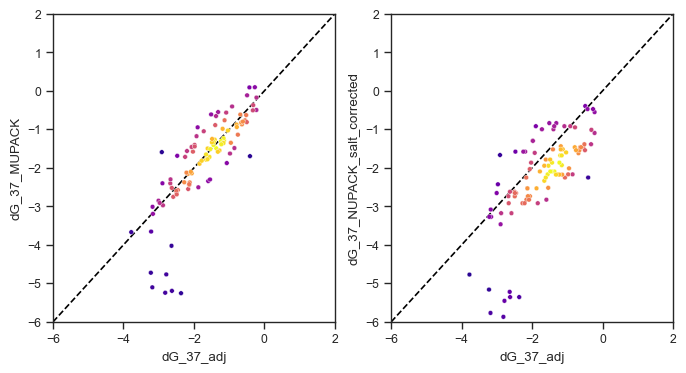

In [161]:
lim = [-6,2]
fig, ax = plt.subplots(1,2,figsize=(8,4))
plotting.plot_colored_scatter_comparison(data=arr.loc[triloop_ind], x='dG_37_adj', y='dG_37_MUPACK', 
                                         lim=lim, ax=ax[0], show_cbar=False)

plotting.plot_colored_scatter_comparison(data=arr.loc[triloop_ind], x='dG_37_adj', y='dG_37_NUPACK_salt_corrected', 
                                         lim=lim, ax=ax[1], show_cbar=False)


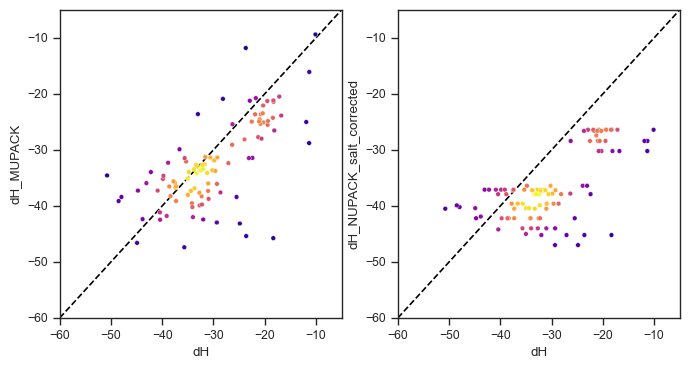

In [162]:
lim = [-60,-5]
fig, ax = plt.subplots(1,2,figsize=(8,4))
plotting.plot_colored_scatter_comparison(data=arr.loc[triloop_ind], x='dH', y='dH_MUPACK', 
                                         lim=lim, ax=ax[0], show_cbar=False)

plotting.plot_colored_scatter_comparison(data=arr.loc[triloop_ind], x='dH', y='dH_NUPACK_salt_corrected', 
                                         lim=lim, ax=ax[1], show_cbar=False)


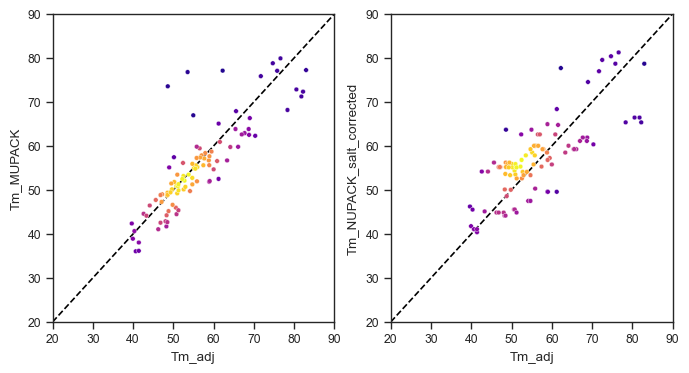

In [167]:
lim = [20,90]
fig, ax = plt.subplots(1,2,figsize=(8,4))
plotting.plot_colored_scatter_comparison(data=arr.loc[triloop_ind], x='Tm_adj', y='Tm_MUPACK', 
                                         lim=lim, ax=ax[0], show_cbar=False)

plotting.plot_colored_scatter_comparison(data=arr.loc[triloop_ind], x='Tm_adj', y='Tm_NUPACK_salt_corrected', 
                                         lim=lim, ax=ax[1], show_cbar=False)


I do see some improvements here.

# Look at UV triloops now

In [168]:
triloop_ind = [x for x in uv_df.index if x.startswith('TRI')]

In [170]:
%%time
pred = list(arr.loc[triloop_ind,:].apply(lambda row: util.get_nupack_dH_dS_Tm_dG_37(row.RefSeq, row.TargetStruct, sodium=0.088, return_dict=False, param_set='./models/dna-nnn.json'), axis=1))
# arr[['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = pred

arr[['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = np.nan
arr.loc[triloop_ind, ['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = pred

arr.dG_37_MUPACK += ddG
arr.Tm_MUPACK = util.get_Tm(arr.dH_MUPACK, arr.dG_37_MUPACK)

CPU times: user 502 ms, sys: 8.98 ms, total: 511 ms
Wall time: 512 ms


In [192]:
cols = ['dG_37_uv', 'Tm_uv', 'dH_uv']
uv = uv_df.query('Na_mM == 25 & is_hairpin')[cols].groupby('SEQID').apply(np.mean)
arr[cols] = np.nan
arr.loc[triloop_ind, cols] = uv.loc[triloop_ind, cols]

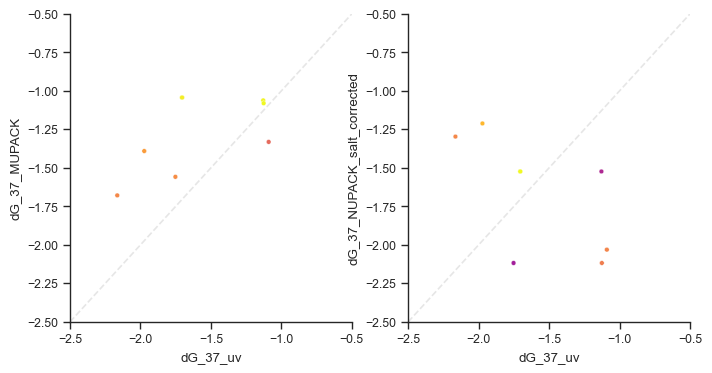

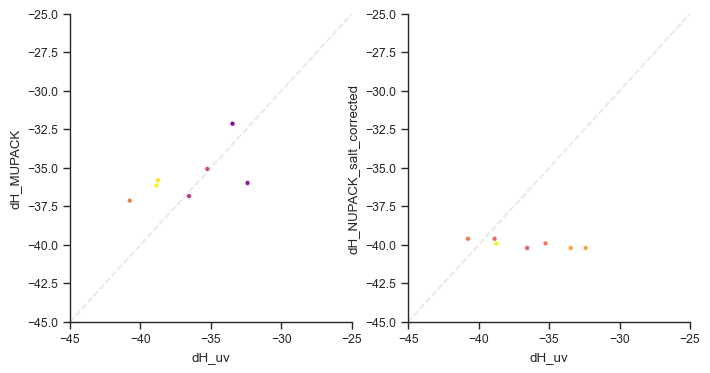

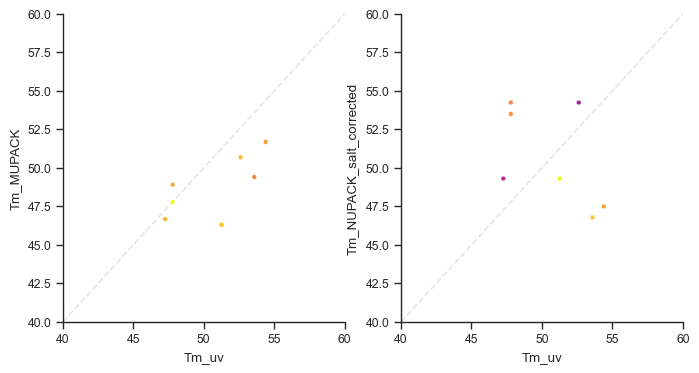

In [206]:
def plot_mupack_nupack(param, lim):
    fig, ax = plt.subplots(1,2,figsize=(8,4))
    plotting.plot_colored_scatter_comparison(data=arr.loc[triloop_ind], x=param+'_uv', y=param+'_MUPACK', 
                                             lim=lim, ax=ax[0], show_cbar=False)

    plotting.plot_colored_scatter_comparison(data=arr.loc[triloop_ind], x=param+'_uv', y=param+'_NUPACK_salt_corrected', 
                                             lim=lim, ax=ax[1], show_cbar=False)
    # plt.show()


plot_mupack_nupack('dG_37', [-2.5,-0.5])
plot_mupack_nupack('dH', [-45, -25])
plot_mupack_nupack('Tm', [40, 60])
util.save_multi_image('./fig/models/MUPACK/model_pred_vs_uv_v0.pdf')

# Take a closer look at the triloop parameters

Can we further reduce the number of parameters?

## Silly UMAP for fun

In [223]:
from src.models import knn
import umap

In [213]:
p_dict = param_set_dict['dG']['hairpin_triloop']

In [220]:
dist_mat = knn.compute_edit_distance(p_dict.keys(), p_dict.keys())

256it [00:00, 8734.72it/s]


In [221]:
dist_mat

array([[0, 2, 2, ..., 5, 5, 5],
       [2, 0, 2, ..., 3, 5, 5],
       [2, 2, 0, ..., 5, 3, 5],
       ...,
       [5, 3, 5, ..., 0, 2, 2],
       [5, 5, 3, ..., 2, 0, 2],
       [5, 5, 5, ..., 2, 2, 0]])

In [236]:
%%time
np.random.seed(42)
embedding = umap.UMAP(n_neighbors=3,
                      min_dist=1,
                      metric='euclidean').fit_transform(dist_mat)

CPU times: user 1.23 s, sys: 42.1 ms, total: 1.27 s
Wall time: 1.03 s


In [237]:
p_df = pd.DataFrame(data=p_dict, index=['dG']).T
p_df[['UMAP_1', 'UMAP_2']]= embedding

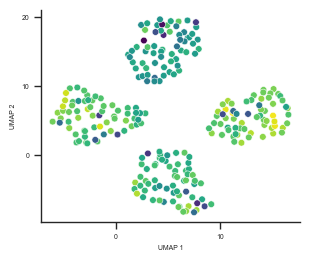

In [239]:
fig, ax = plt.subplots(figsize=(2*4.25*cm, 2*3.5*cm))
sns.scatterplot(data=p_df, x='UMAP_1', y='UMAP_2', hue='dG', 
                alpha=0.99, palette='viridis',
                rasterized=True)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(10))

ax.set_yticklabels(ax.get_yticklabels(), fontsize=tick_font_size)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=tick_font_size)

ax.set_xlabel('UMAP 1', fontsize=tick_font_size)
ax.set_ylabel('UMAP 2', fontsize=tick_font_size)
ax.get_legend().remove()
sns.despine()

(array([ 2304.,  8872., 17568., 25288., 11248.,     0.]),
 array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <BarContainer object of 6 artists>)

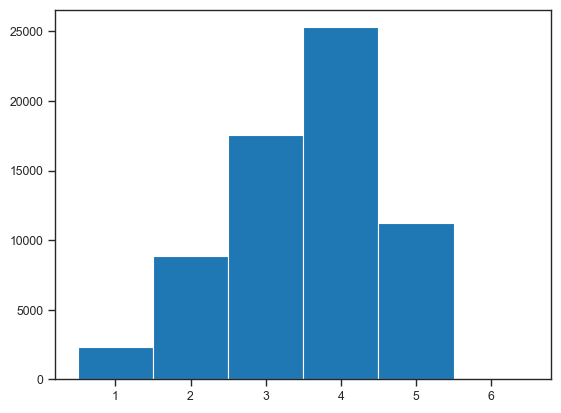

In [242]:
plt.hist(dist_mat.flatten(), bins=np.arange(.5,7.5))

## Dictionary learining example

In [1]:
import numpy as np
from sklearn.datasets import make_sparse_coded_signal
from sklearn.decomposition import DictionaryLearning
X, dictionary, code = make_sparse_coded_signal(
    n_samples=100, n_components=15, n_features=20, n_nonzero_coefs=10,
    random_state=42, data_transposed=False
)
dict_learner = DictionaryLearning(
    n_components=15, transform_algorithm='lasso_lars', transform_alpha=0.1,
    random_state=42,
)
X_transformed = dict_learner.fit_transform(X)

In [6]:
X.shape, dictionary.shape, code.shape

((100, 20), (15, 20), (100, 15))

In [9]:
X_transformed.shape

(100, 15)

In [10]:
np.mean(X_transformed == 0)

0.41733333333333333

In [11]:
X_hat = X_transformed @ dict_learner.components_

In [14]:
np.mean(np.sum((X_hat - X) ** 2, axis=1) / np.sum(X ** 2, axis=1))

0.07777084613290736

## Apply dictionary learning to triloop parameters

In [ ]:
import numpy as np
from sklearn.datasets import make_sparse_coded_signal
from sklearn.decomposition import DictionaryLearning

In [36]:
def onehot_nucleotide(seq_str):
    map_dict = dict(A=0, T=1, C=2, G=3)
    N = len(seq_str)
    encode_arr = np.zeros((N, 4))
    for i,x in enumerate(seq_str.upper()):
        encode_arr[i, map_dict[x]] = 1
    return encode_arr

In [21]:
"""
Enumerate all possible triloops and one-hot encode
"""
from scripts.make_lib3 import *

loops = def_triloops()
pairs = def_pairs()

triloops = []
for loop in loops:
    triloops += add_loop_2_seqs(loop, pairs)

X = np.array([onehot_nucleotide(triloop).flatten() for triloop in triloops])
X.shape

### One model

In [54]:
%%time
dict_learner = DictionaryLearning(
    n_components=10, transform_algorithm='lasso_lars', transform_alpha=0.1,
    random_state=42,
)
X_transformed = dict_learner.fit_transform(X)

CPU times: user 5 s, sys: 920 ms, total: 5.92 s
Wall time: 4.83 s


In [55]:
np.mean(X == 0), np.mean(X_transformed == 0)

(0.75, 0.3083984375)

In [56]:
X_hat = X_transformed @ dict_learner.components_
np.mean(np.sum((X_hat - X) ** 2, axis=1) / np.sum(X ** 2, axis=1))

0.3781159065112989

### Parameter sweep

In [81]:
%%time
"""
Find a good n_components
"""
psweep = np.arange(14,19)
sparsity, rmse = np.zeros(len(psweep)), np.zeros(len(psweep))
for i,n_components in enumerate(psweep):
    dict_learner = DictionaryLearning(
        n_components=n_components, transform_algorithm='lasso_lars', transform_alpha=0.01,
        random_state=42,
    )
    X_transformed = dict_learner.fit_transform(X)
    sparsity[i] = np.mean(X_transformed == 0)
    X_hat = X_transformed @ dict_learner.components_
    rmse[i] = np.mean(np.sum((X_hat - X) ** 2, axis=1) / np.sum(X ** 2, axis=1))

CPU times: user 1min 40s, sys: 2min 56s, total: 4min 36s
Wall time: 1min


(0.0, 0.10492250360873222)

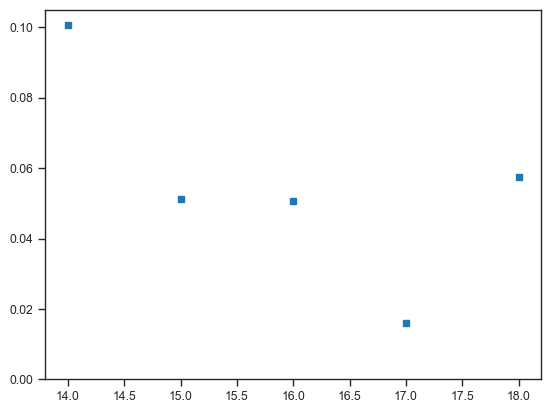

In [82]:
plt.plot(psweep, rmse, 's')
plt.ylim(bottom=0)

(0.0, 0.22292364211309523)

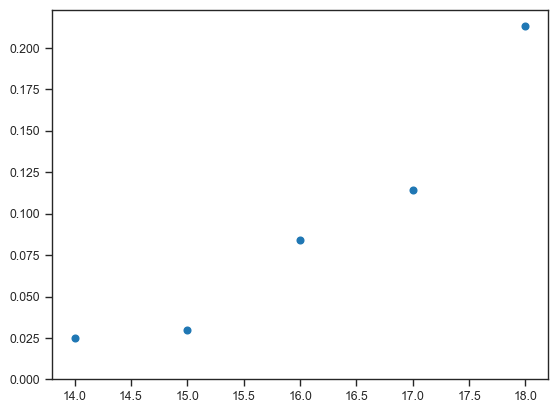

In [83]:
plt.plot(psweep, sparsity, 'o')
plt.ylim(bottom=0)

I'll just take 17 dims. Good enough.

Next I'll implement it in the feature extractor.

## to `feature_list`

First fit and save the chosen model

In [84]:
%%time
dict_learner = DictionaryLearning(
    n_components=17, transform_algorithm='lasso_lars', transform_alpha=0.01,
    random_state=42,
)
X_transformed = dict_learner.fit_transform(X)

CPU times: user 27 s, sys: 47.3 s, total: 1min 14s
Wall time: 15.9 s


In [85]:
fileio.write_pickle(dict_learner, './data/models/saved/triloop_dict_learner.pkl')

In [101]:
param_set_file = './models/dna-nnn.json'
param_set_dict = fileio.read_json(param_set_file)

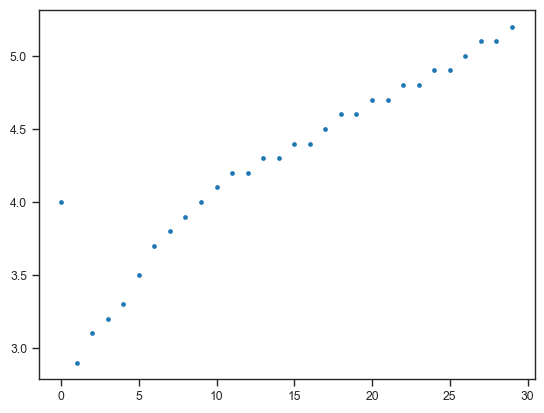

In [104]:
plt.plot(param_set_dict['dG']['bulge_size'], '.')

### Test `get_nupack_feature_list`

In [105]:
from RiboGraphViz import LoopExtruder, StackExtruder
from nnn import feature_list

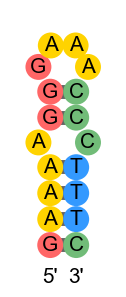

['interior_size$2',
 'interior_mismatch$CTAA',
 'interior_mismatch$AGCC',
 'hairpin_size$4',
 'hairpin_tetraloop$GGAAAC',
 'stack$AATT',
 'stack$AATT',
 'stack$GATC',
 'terminal_penalty$GC',
 'stack$GGCC']

In [195]:
seqid = 'MMACP10'
seq = arr.loc[seqid, 'RefSeq']
struct = arr.loc[seqid, 'TargetStruct']
draw_struct(seq, struct)
feature_list.get_nupack_feature_list(arr.loc[seqid])

### Extract all nupack features

In [250]:
arr_1M = pd.read_csv('./data/models/raw/arr_1M.csv', index_col=0)
data_split_dict = fileio.read_json('./data/models/raw/data_split.json')

In [245]:
%%time
feats = mf.get_feature_count_matrix(arr_1M, feature_method='get_nupack_feature_list', 
                                    feature_style='nupack', fit_intercept=False)
print(feats.shape)
feats

(30853, 1429)
CPU times: user 14.7 s, sys: 163 ms, total: 14.9 s
Wall time: 14.9 s


,bulge_size#1,bulge_size#2,hairpin_mismatch#ATAT,hairpin_mismatch#CGCG,hairpin_mismatch#GCGC,hairpin_size#10,hairpin_size#11,hairpin_size#12,hairpin_size#13,hairpin_size#14,...,terminal_mismatch#TGCC,terminal_mismatch#TGCG,terminal_mismatch#TGCT,terminal_mismatch#TTAC,terminal_mismatch#TTAG,terminal_mismatch#TTAT,terminal_penalty#AT,terminal_penalty#CG,terminal_penalty#GC,terminal_penalty#TA
SEQID,,,,,,,,,,,,,,,,,,,,,
BC0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
BC1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
BC10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
BC11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
BC15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
varloop257601,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
varloop257621,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
varloop257641,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [220]:
feats.loc[feats['interior_size#6'] == 1]

,bulge_size#1,bulge_size#2,bulge_size#3,bulge_size#4,bulge_size#5,bulge_size#6,bulge_size#7,bulge_size#8,hairpin_mismatch#ATAT,hairpin_mismatch#CGCG,...,terminal_mismatch#TGCC,terminal_mismatch#TGCG,terminal_mismatch#TGCT,terminal_mismatch#TTAC,terminal_mismatch#TTAG,terminal_mismatch#TTAT,terminal_penalty#AT,terminal_penalty#CG,terminal_penalty#GC,terminal_penalty#TA
SEQID,,,,,,,,,,,,,,,,,,,,,
SD114,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SD146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SD50,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SD6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SD82,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [216]:
arr.loc['SD121']

dH                                             -3.522595
dH_se                                           0.544598
dH_lb                                          -5.008263
dH_ub                                          -2.856465
Tm                                             21.997514
Tm_se                                           5.429109
Tm_lb                                           5.091963
Tm_ub                                          40.267232
dG_37                                           0.197103
dG_37_se                                        0.116059
dG_37_lb                                        -0.04588
dG_37_ub                                        0.599265
dS                                             -0.011975
dS_se                                            0.00212
dS_lb                                          -0.017795
dS_ub                                          -0.009166
fmax                                            1.021938
fmax_se                        

CPU times: user 2min 44s, sys: 2min 10s, total: 4min 54s
Wall time: 1min 7s


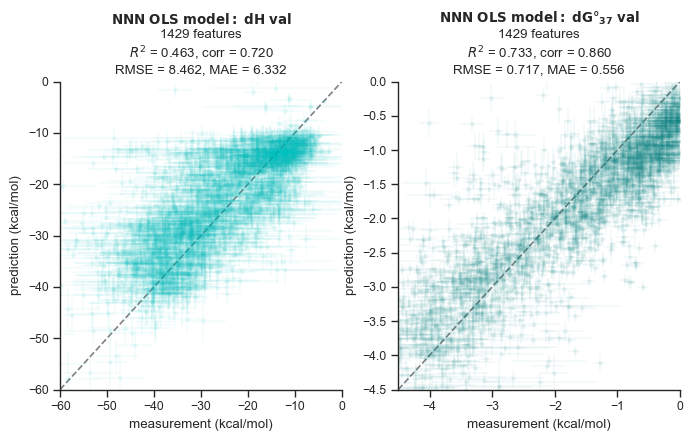

In [251]:
%%time 
fig, ax = plt.subplots(1, 2, figsize=(8,4))
lr_dH = mf.fit_param(arr_1M, data_split_dict, param='dH', feats=feats, ax=ax[0])
lr_dG = mf.fit_param(arr_1M, data_split_dict, param='dG_37', feats=feats, ax=ax[1])

This is worse than my parameterization. At least for dH. dG is similar.

Need to convert fitted parameters to the json file.

> Note that mismatches are kept in a lookup table calculated from the fitted terminal or interior mm parameters.

(array([  1.,   2.,  20.,  43., 425., 779., 146.,   8.,   3.,   2.]),
 array([-37.25473194, -30.16226033, -23.06978873, -15.97731712,
         -8.88484552,  -1.79237391,   5.30009769,  12.3925693 ,
         19.4850409 ,  26.57751251,  33.66998411]),
 <BarContainer object of 10 artists>)

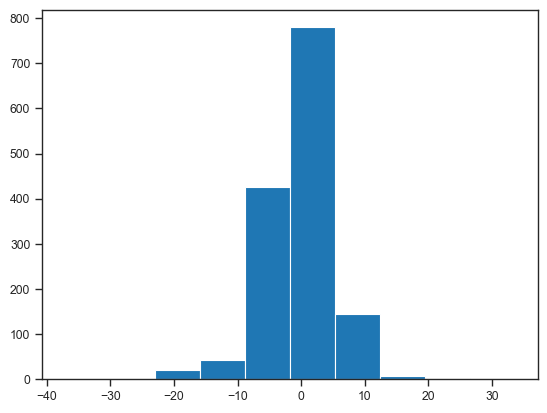

In [254]:
plt.hist(lr_dH.coef_)

In [255]:
lr_dG.coef_df.query('dG_37 < 1e-2')

,dG_37
bulge_size#2,-3.316489e+00
hairpin_mismatch#ATAT,5.837389e-14
hairpin_mismatch#CGCG,9.186212e-14
hairpin_mismatch#GCGC,-1.886526e+00
hairpin_size#10,-3.300048e+00
...,...
terminal_mismatch#TATG,-1.372310e-01
terminal_mismatch#TCGG,-4.522346e-01
terminal_mismatch#TGCG,-4.899013e-01
terminal_mismatch#TGCT,-1.629468e-01


In [256]:
len(lr_dG.coef_)

1429

In [257]:
660/1429

0.46186144156752973